# Исследование сервиса аренды самокатов GoFast

В вашем распоряжении данные о некоторых пользователях из нескольких городов, а также об их поездках. users_go.csv - данные о пользователях, rides_go.csv - данные о поездках, subscriptions_go.csv - данные о подписках.

Цель исследования — проверьте гипотезы:

- Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.
- Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
- Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Ход исследования: 

Получить данные из users_go.csv - данные о пользователях, rides_go.csv - данные о поездках, subscriptions_go.csv - данные о подписках. О качестве данных ничего не известно. Поэтому перед проверкой гипотез понадобится обзор данных.

Проверить данные на ошибки и оцените их влияние на исследование. 

Описать и визуализировать общую информацию о пользователях и поездках.

Объеденить данные.

Подсчитать выручку.

Проверить гипотезы.

In [1]:
import pandas
import pandas as pd
import matplotlib.pyplot as plt # для постройки графиков
import seaborn # для диаграммы
import numpy as np # каждое значение из столбца duration округляется с помощью «потолка»: 
from scipy import stats as st # для проверки гипотезы в Python
from math import factorial # для вероятностей
from math import sqrt # для вероятностей
from scipy.stats import binom # для вероятностей

#### Шаг 1. Загрузка данных

Данные с пользователями

In [2]:
try:
    data_users_go = pd.read_csv('/datasets/users_go.csv')
except:
    data_users_go = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')

Посмотрим общую информацию data_users_go

In [3]:
data_users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Выведем первые 15 строк

In [4]:
data_users_go.head(15)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


Посмотрим количество пользователей в разных городах

In [5]:
users_go_city = data_users_go['city'].value_counts()
users_go_city

Пятигорск         226
Екатеринбург      206
Ростов-на-Дону    202
Краснодар         196
Сочи              192
Омск              186
Тюмень            185
Москва            172
Name: city, dtype: int64

Наибольшее количество пользователей в Пятигорске

Количество пользователей имеющие разные подписки

In [6]:
users_go_subscription_type = data_users_go['subscription_type'].value_counts()
users_go_subscription_type

free     846
ultra    719
Name: subscription_type, dtype: int64

Большенства пользователей не имеют подписку

Данные с поездками

In [7]:
try:
    data_rides_go = pd.read_csv('/datasets/rides_go.csv')
except:
    data_rides_go = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')

Выведем общую информацию

In [8]:
data_rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Выведем первые 15 строк

In [9]:
data_rides_go.head(15)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


Количество поездок которые совершили пользователи

In [10]:
rides_go_user_id_colichestvo = data_rides_go['user_id'].value_counts()
rides_go_user_id_colichestvo.head(15)

1236    27
783     26
1063    26
1204    24
1149    23
716     23
1531    23
1030    23
1049    22
895     22
709     22
1383    22
734     22
1421    22
898     22
Name: user_id, dtype: int64

Общая дистанция и время, проведенное в поездках каждым пользователем

In [11]:
rides_go_d_t = data_rides_go.groupby(['user_id']).sum('duration')
rides_go_d_t.head(15)

,distance,duration
user_id,,
1,34070.182066,204.604909
2,33964.058614,197.644279
3,36907.597866,233.193513
4,44837.189916,288.563581
5,35556.949649,174.073932
6,34078.606693,203.299077
7,48707.479147,258.371222
8,15754.261455,90.681387
9,23730.942270,129.790228


Данные с подписками

In [12]:
try:
    data_subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    data_subscriptions_go = pd.read_csv('https://code.s3.yandex.net/subscriptions_go.csv')

Выведем общую информацию

In [13]:
data_subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Выведем первые 15 строк

In [14]:
data_subscriptions_go.head(15)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [15]:
#вывод сделать

Во время просмотра информации пропущенные значения не наблюдаются, наименование столбцов корректные. 
В data_rides_go.info в столбцп date необходимо будет поменять типу даты pandas.
Исходя из данных можно сказать что, больше всего пользователей имеет г. Пятигорск. Так большенства пользователей не имеют подписку. 

#### Шаг 2. Предобработка данных

Проверим таблицы на наличие пропусков

In [16]:
data_users_go.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [17]:
data_rides_go.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [18]:
data_subscriptions_go.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Приведем в таблице data_rides_go столбец date к типу даты pandas.

In [19]:
data_rides_go['date'] = pd.to_datetime(data_rides_go['date'], format = '%Y-%m-%d')

In [20]:
data_rides_go['date'].head()

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

В таблице data_rides_go ждобавим столбец, обозначающий месяц

Узнаем за какой период представлены данные

In [21]:
data_rides_go['date'].unique()

array(['2021-01-01T00:00:00.000000000', '2021-01-18T00:00:00.000000000',
       '2021-04-20T00:00:00.000000000', '2021-08-11T00:00:00.000000000',
       '2021-08-28T00:00:00.000000000', '2021-10-09T00:00:00.000000000',
       '2021-10-19T00:00:00.000000000', '2021-11-06T00:00:00.000000000',
       '2021-11-14T00:00:00.000000000', '2021-11-22T00:00:00.000000000',
       '2021-12-14T00:00:00.000000000', '2021-12-22T00:00:00.000000000',
       '2021-03-15T00:00:00.000000000', '2021-03-18T00:00:00.000000000',
       '2021-03-23T00:00:00.000000000', '2021-04-08T00:00:00.000000000',
       '2021-04-13T00:00:00.000000000', '2021-06-20T00:00:00.000000000',
       '2021-07-02T00:00:00.000000000', '2021-07-18T00:00:00.000000000',
       '2021-08-03T00:00:00.000000000', '2021-10-27T00:00:00.000000000',
       '2021-12-18T00:00:00.000000000', '2021-01-31T00:00:00.000000000',
       '2021-02-24T00:00:00.000000000', '2021-02-26T00:00:00.000000000',
       '2021-04-12T00:00:00.000000000', '2021-05-07

Видим только 2021 год, добавим столбец с месяцем

In [22]:
data_rides_go['month'] = data_rides_go['date'].dt.month

In [23]:
data_rides_go.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Добавим в data_rides_go с длительностью поездки в секундах

Проверем наличие пропущенных значений и дубликатов в датафреймах.

In [24]:
data_users_go.duplicated().sum()

31

In [25]:
data_rides_go.duplicated().sum()

0

In [26]:
data_subscriptions_go.duplicated().sum()

0

Удалим дубликаты в data_users_go

In [27]:
data_users_go.drop_duplicates(inplace=True)

In [28]:
data_users_go.duplicated().sum()

0

In [29]:
data_users_go.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


Пропуски не были найдены в процессе провеки, был изменен формат в data_rides_go столбце date к типу даты pandas.
В таблице data_rides_go ждобавим столбец, обозначающий месяц.
Были убраны дубликаты в data_users_go

#### Шаг 3. Исследовательский анализ данных

3.1 частота встречаемости городов

In [30]:
users_go_city = data_users_go['city'].value_counts()
users_go_city

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [31]:
xxx = pandas.Series([219, 204, 198, 193, 189, 183, 180, 168])
yyy = pandas.Series(['Пятигорск', 'Екатеринбург', 'Ростов-на-Дону', 'Краснодар', 'Сочи', 'Омск', 'Тюмень', 'Москва'])

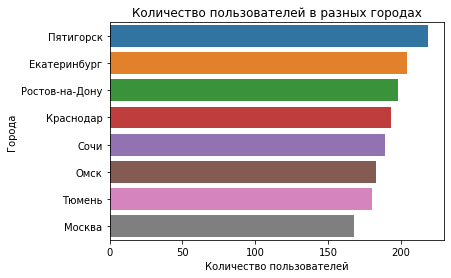

In [32]:
seaborn.barplot(x=xxx, y=yyy)
plt.title('Количество пользователей в разных городах')
plt.xlabel('Количество пользователей')
plt.ylabel('Города')

plt.show()

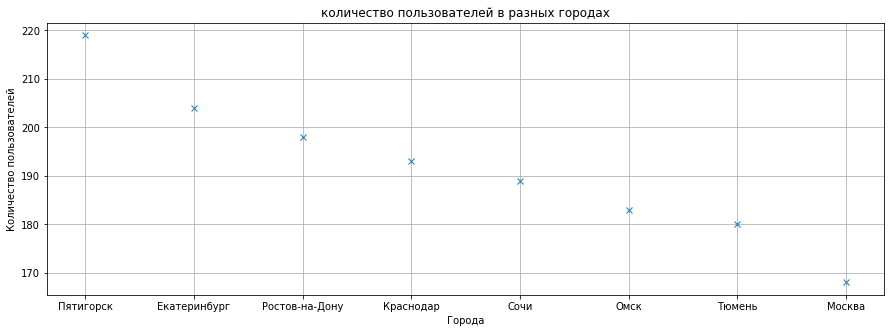

In [33]:
users_go_city.plot(style='x', title ='количество пользователей в разных городах', grid=True, figsize=(15, 5))
plt.xlabel('Города')
plt.ylabel('Количество пользователей')

plt.show()

Наиболее распространный город является Пятигорск, Екатеренбург и Ростов-на-Дону, меньше всего пользователей в Моксве и Тюмени.
Сильно выделяющегося по количеству городу пользователей нет, так в Пятигорске 219 пользователей, когда как в Москве, где меньше всего пользователей, 168, что на 51 пользователя меньше чем в лидируещем по количеству пользователей г. Пятигорска.

3.2 соотношение пользователей с подпиской и без подписки;

In [34]:
users_go_subscription_type = data_users_go['subscription_type'].value_counts()
users_go_subscription_type

free     835
ultra    699
Name: subscription_type, dtype: int64

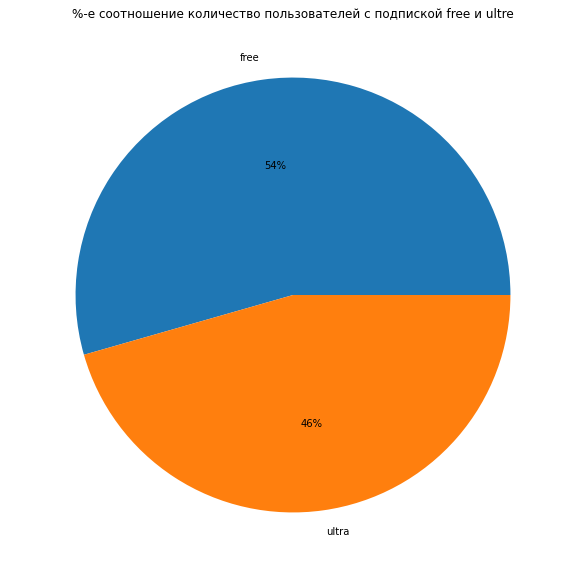

In [35]:
users_go_subscription_type.plot(kind='pie', title ='%-е соотношение количество пользователей с подпиской free и ultre', grid=True, autopct = '%1.0f%%', figsize=(10,10))
plt.ylabel(' ')


plt.show()

Чуть больше половины пользователей (54%) не имеют подписки. Платную подписку имеют 46% пользователей.

3.3 возраст пользователей;

Посмотрим количество пользователей по годам

In [36]:
users_go_age = data_users_go['age'].value_counts()
users_go_age

25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
34     19
16     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: age, dtype: int64

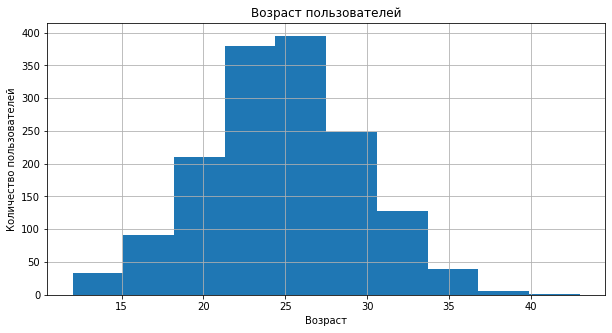

In [37]:
data_users_go['age'].plot(kind='hist', title ='Возраст пользователей', grid=True, figsize=(10,5))
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')

plt.show()

Самые старшие и младшие пользователи

In [38]:
data_users_go['age'].sort_values().head()

664    12
66     12
727    12
34     12
235    13
Name: age, dtype: int64

In [39]:
data_users_go['age'].sort_values(ascending=False).head()

1201    43
961     39
804     38
453     38
383     38
Name: age, dtype: int64

Большую часть пользователей составляют от 20 до 30 лет, больше всего пользователей имеют возраст 24-26 лет. Диапозон возраста пользователей составляет от 12 до 43 лет.

3.4 расстояние, которое пользователь преодолел за одну поездку;

Самые короткие и длинные дистанции за одну поездку:

In [40]:
round(data_rides_go['distance'].sort_values(), 2).head()

11555    0.86
9541     2.57
13690    4.33
8658     6.78
7841     7.10
Name: distance, dtype: float64

In [41]:
round(data_rides_go['distance'].sort_values(ascending=False), 2).head()

16309    7211.01
16484    7066.00
15580    6908.49
17171    6760.94
17242    6724.93
Name: distance, dtype: float64

In [42]:
print(data_rides_go['distance'].describe())

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64


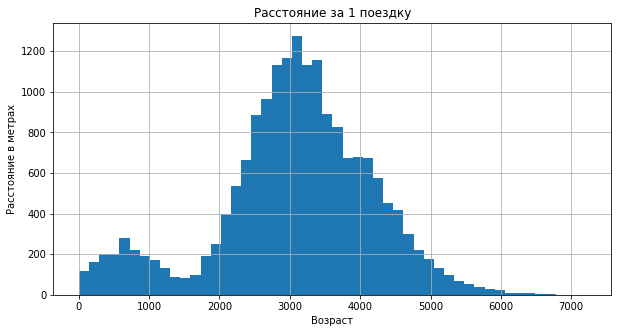

In [43]:
data_rides_go['distance'].plot(kind='hist', title ='Расстояние за 1 поездку', bins = 50, grid=True, figsize=(10,5))
plt.xlabel('Возраст')
plt.ylabel('Расстояние в метрах')

plt.show()

В основном пользователи проезжают от 2.5 км до 3,7 км. Максимальное расстояние за одну поездку составляет 7211,01 м.

3.5 Продолжительность поездок.

Посмотрим минимальные и максимальные по времени поезки

In [44]:
data_rides_go['duration'].sort_values().head()

12013    0.5
17314    0.5
15029    0.5
7437     0.5
12967    0.5
Name: duration, dtype: float64

In [45]:
data_rides_go['duration'].sort_values(ascending=False).head()

4215    40.823963
4709    39.873856
2623    39.526602
1998    38.352763
6453    38.265229
Name: duration, dtype: float64

In [46]:
#print('в минутах', data_rides_go['duration'].min())

In [47]:
#print('в минутах', round(data_rides_go['duration'].max(), 2))

In [48]:
#print('среднее арифметическое', round(data_rides_go['duration'].mean(), 2))

In [49]:
#print('медиана', round(data_rides_go['duration'].median(), 2))

In [50]:
print(data_rides_go['duration'].describe())

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64


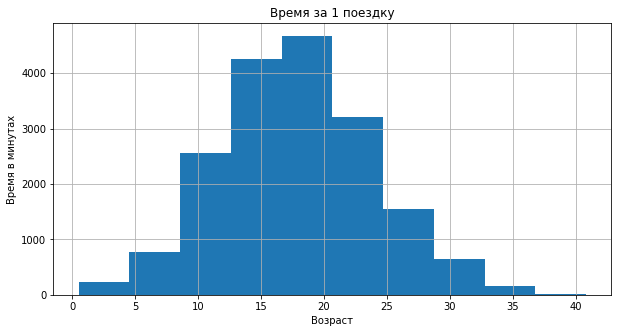

In [51]:
data_rides_go['duration'].plot(kind='hist', title ='Время за 1 поездку', grid=True, figsize=(10,5))
plt.xlabel('Возраст')
plt.ylabel('Время в минутах')

plt.show()

Чаще всего длительность поездки состовляет 13 - 21 минут. Максимальное время поездки составило 40,82 минуты.

Наиболее распространный город является Пятигорск, Екатеренбург и Ростов-на-Дону, меньше всего пользователей в Моксве и Тюмени. 
Чуть больше половины пользователей (54%) не имеют подписки. Платную подписку имеют 46% пользователей.
Больше всего пользователей возраста от 20 до 30 лет. Диапозон возраста пользователей составляет от 12 до 43 лет.
В основном пользователи проезжают от 2.5 км до 3,7 км. Максимальное расстояние за одну поездку составляет 7211,01 м.
Чаще всего длительность поездки состовляет 13 - 21 минут. Максимальное время поездки составило 40,82 минуты.

#### Шаг 4. Объединение данных

4.1 Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом merge().

In [52]:
data_users_go.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


In [53]:
data_rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [54]:
data_subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [55]:
itog_data = data_users_go.merge(data_rides_go, on='user_id')

In [56]:
itog_data = itog_data.merge(data_subscriptions_go, on='subscription_type')

In [57]:
itog_data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [58]:
itog_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


4.2 Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1:

Создадитм датафрейм без подписки

In [59]:
free_subscription_data = itog_data.query("subscription_type == 'free'")

In [60]:
free_subscription_data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


Создадим датафрейм с данными о пользователях с подпиской.

In [61]:
ultra_subscription_data = itog_data.query("subscription_type == 'ultra'")

In [62]:
ultra_subscription_data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


4.3 Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.

Визуализируем информацию о расстоянии на бесплатном тарифе

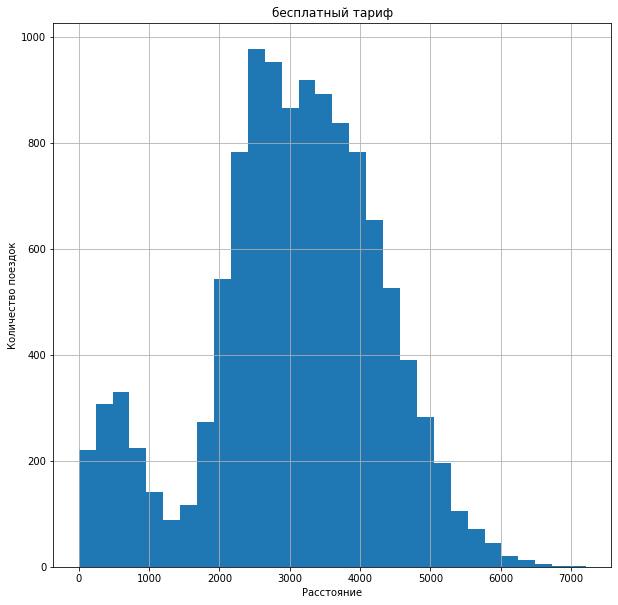

In [63]:
free_subscription_data['distance'].plot(kind='hist', title ='бесплатный тариф', bins=30, grid=True, figsize=(10,10))
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')

plt.show()

В основном пользователи без подписки проезжают расстояние от 2000 до 4000 м. На гистограмме можно увидить 2 пика, один небольшой на расстоянии 500 метров и другой 2500 метров. Первый пик можно отнести к пробным заездам, второй пик можно отнести к наиболее частым поездкам.

Визуализируем информацию о времени на бесплатном тарифе

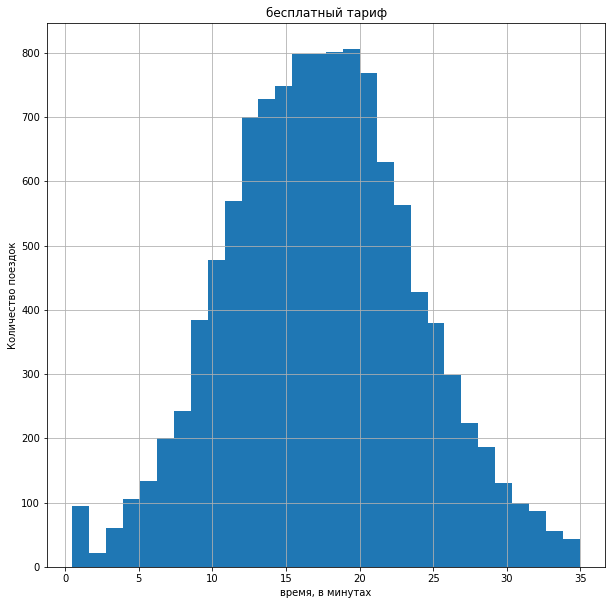

In [64]:
free_subscription_data['duration'].plot(kind='hist', title ='бесплатный тариф', bins=30, grid=True, figsize=(10,10))
plt.xlabel('время, в минутах')
plt.ylabel('Количество поездок')

plt.show()

В основном время поездки у пользователей не имеющих подписку занимает 10-30 минут. Есть незначительный пик около 0, его можно засчитать за пробные поезки, так как на графике расстояния так же есть пик близкий к 0.

Визуализируем информацию о расстоянии на платном тарифе

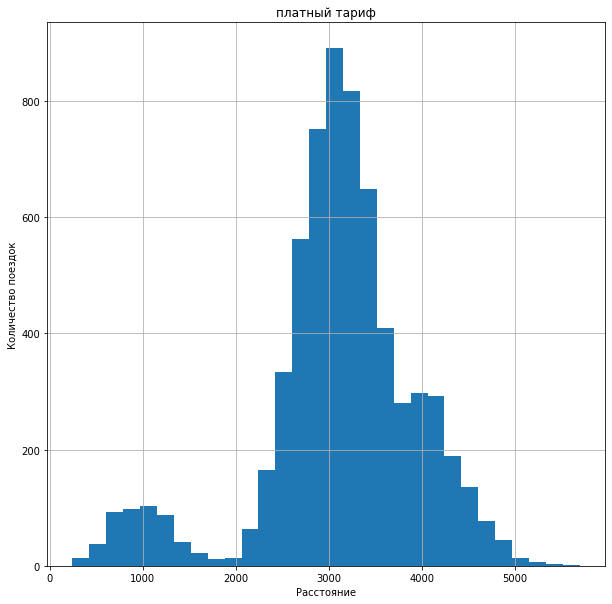

In [65]:
ultra_subscription_data['distance'].plot(kind='hist', title ='платный тариф', bins=30, grid=True, figsize=(10,10))
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')

plt.show()

Чаще всего пользователи с подпиской проезжают 2500 - 4000 м. Пик расстояния приходится на 3км.

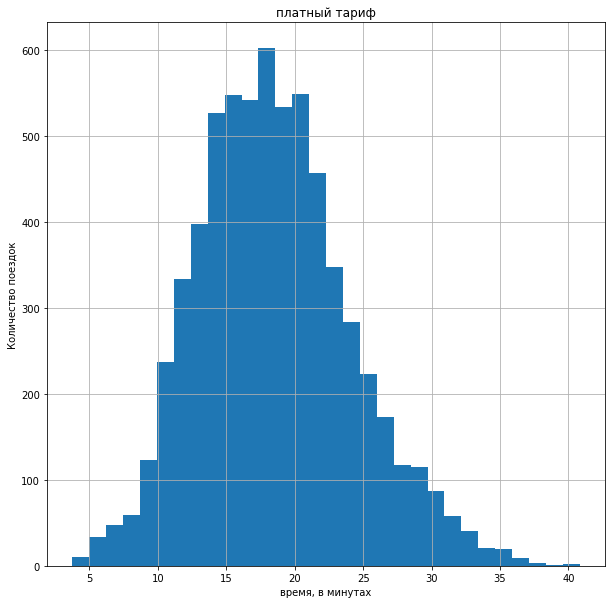

In [66]:
ultra_subscription_data['duration'].plot(kind='hist', title ='платный тариф', bins=30, grid=True, figsize=(10,10))
plt.xlabel('время, в минутах')
plt.ylabel('Количество поездок')

plt.show()

В основном время поездки у пользователей укладывается в промежуток от 10 до 25 минут. 

Обьеденим группы для наглядности о расстоянии и о времени

Text(0, 0.5, 'Количество поездок')

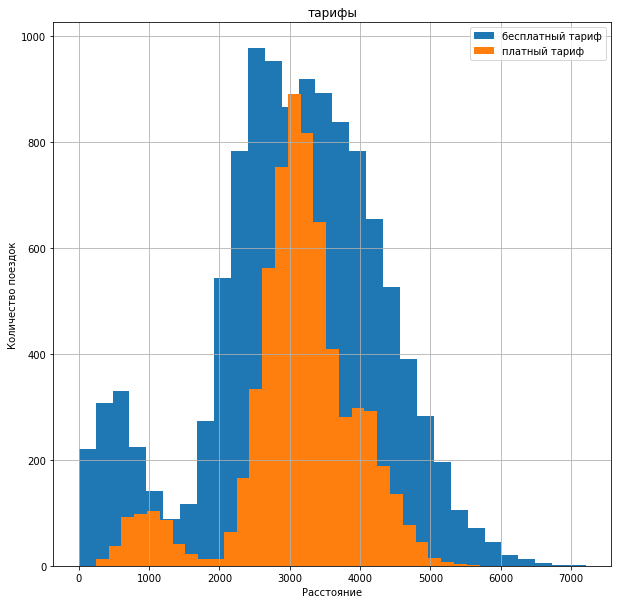

In [67]:
free_subscription_data['distance'].plot(kind='hist', title ='тарифы', bins=30, grid=True, figsize=(10,10))
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.legend(['бесплатный тариф', 'платный тариф'])

ultra_subscription_data['distance'].plot(kind='hist', title ='тарифы', bins=30, grid=True, figsize=(10,10))
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')

Text(0, 0.5, 'Количество поездок')

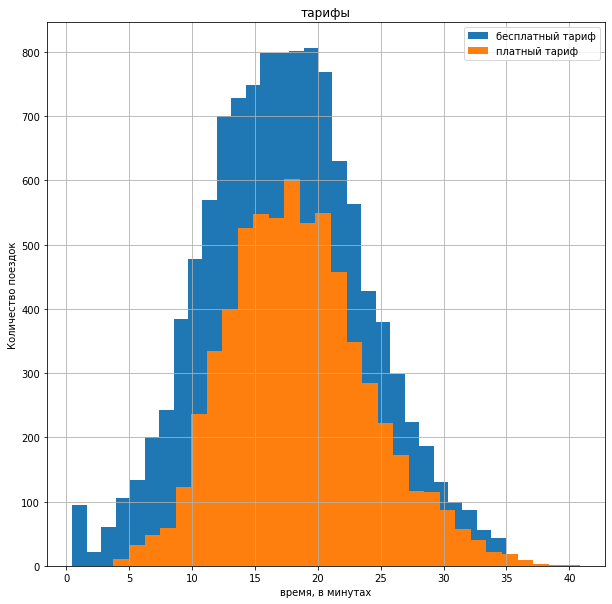

In [68]:
free_subscription_data['duration'].plot(kind='hist', title ='тарифы', bins=30, grid=True, figsize=(10,10))
plt.xlabel('время, в минутах')
plt.ylabel('Количество поездок')
plt.legend(['бесплатный тариф', 'платный тариф'])

ultra_subscription_data['duration'].plot(kind='hist', title ='тарифы', bins=30, grid=True, figsize=(10,10))
plt.xlabel('время, в минутах')
plt.ylabel('Количество поездок')

In [69]:
print('данные о растоянии беслпатного тарифа:', free_subscription_data['distance'].describe())

данные о растоянии беслпатного тарифа: count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64


In [70]:
print('данные о времени беслпатного тарифа:', free_subscription_data['duration'].describe())

данные о времени беслпатного тарифа: count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64


In [71]:
print('данные о растоянии платного тарифа:', ultra_subscription_data['distance'].describe())

данные о растоянии платного тарифа: count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64


In [72]:
print('данные о времени платного тарифа:', ultra_subscription_data['duration'].describe())

данные о времени платного тарифа: count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64


Объединили данные о пользователях, поездках и подписках в один датафрейм. На основе объединенного датафрейма создали еще 2 датафрейма: Для пользователей с ultra подпиской и free подпиской
В основном пользователи без подписки проезжают расстояние от 2366 до 3905 м, Так же наблюдается 2 пика, один небольшой на расстоянии 500 метров и другой 2500 метров. Первый пик можно отнести к пробным заездам, второй пик можно отнести к наиболее частым поездкам. Время поездки занимает в среднем 12-21 минут. 
Пользователи с подпиской чаще всего проезжают 2785 - 3560 м. Пик расстояния приходится на 3км. Время поездки занимает в среднем 14-21 минут.
Так как численность пользователей без подписка больше, то диапозон расстояния в среднем шире, от 2366 до 3905 м, однако пользователи с платной подпиской минимальные поездки совершают на более дальние поздки дальше.

#### Шаг 5. Подсчёт выручки

5.1 Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

5.2 В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения 
25.3
25.3, 
25.5
25.5 и 
26.0
26.0 должны быть преобразованы к 
26
26.

Создим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными. Найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [73]:
itog_data['duration'] = np.ceil(itog_data['duration'])

In [74]:
new_data = pd.pivot_table(itog_data, index=['month', 'user_id'], values = ['distance', 'duration', 'name', 'subscription_type'], aggfunc = {'distance': sum, 'duration' : sum, 'name' : len, 'subscription_type' : min})

In [75]:
new_data.rename(columns = {'name' : 'name_count'}, inplace = True)

In [76]:
new_data.sort_values(by='month').head(10)

distance  duration  name_count subscription_type
month user_id                                                      
1     1         7027.511294      42.0           2             ultra
      1061     12637.249630      43.0           3              free
      1063      3276.362299      10.0           1              free
      1064      5297.324649      15.0           1              free
      1065     14547.099333      99.0           4              free
      1066      2809.064949      19.0           1              free
      1067      3864.900780      22.0           1              free
      1069      7007.076943      53.0           3              free
      1071      3635.094136      15.0           1              free
      1072      2498.615999      11.0           1              free

Добавим столбец с помесячной выручкой

In [77]:
def ii(bb):
    if bb['subscription_type'] == 'ultra':
        return 6 * bb['duration'] + 199
    elif bb['subscription_type'] == 'free':
        return 50 * bb['name_count'] + 8 * bb['duration']

In [78]:
new_data['revenue_name'] = new_data.apply(ii, axis=1)

In [79]:
new_data['revenue_name'].head(10)

month  user_id
1      1          451.0
       3          277.0
       5          277.0
       7          367.0
       12         397.0
       13         451.0
       14         409.0
       15         433.0
       20         373.0
       22         277.0
Name: revenue_name, dtype: float64

In [80]:
new_data.head(10)

distance  duration  name_count subscription_type  \
month user_id                                                        
1     1        7027.511294      42.0           2             ultra   
      3        3061.777147      13.0           1             ultra   
      5        3914.646990      13.0           1             ultra   
      7        6478.080979      28.0           2             ultra   
      12       3577.151148      33.0           1             ultra   
      13       6687.987446      42.0           2             ultra   
      14       7699.643820      35.0           2             ultra   
      15       4187.621459      39.0           1             ultra   
      20       3516.719208      29.0           1             ultra   
      22       3058.692225      13.0           1             ultra   

               revenue_name  
month user_id                
1     1               451.0  
      3               277.0  
      5               277.0  
      7               367.0  
      12              397.0  
      13              451.0  
      14              409.0  
      15              433.0  
      20              373.0  
      22              277.0

Создали новый датафрейм с агрегированными данными о поездках new_data на основе датафрейма с объединенными данными itog_data.
Нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Также добавили столбец revenue_name с помесячной выручкой, которую принес каждый пользователь.

#### Шаг 6. Проверка гипотез

6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Проверим гипотезу: пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе.

H0: Время (duration) пользователей на подписке ultra = время (duration) пользователей на подписке free

H1: Время (duration) пользователей на подписке ultra > время (duration) пользователей на подписке free

alpha = 0.05

In [81]:
hypothesis_one_ultra = ultra_subscription_data['duration']

In [82]:
hypothesis_one_free = free_subscription_data['duration']

In [83]:
alpha = 0.05

In [84]:
results = st.ttest_ind(hypothesis_one_ultra, hypothesis_one_free, alternative = 'greater')

In [85]:
print(results.pvalue)

1.2804098316645618e-34


In [86]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


In [87]:
print('Среднее значение с подпиской:', ultra_subscription_data['duration'].mean())

Среднее значение с подпиской: 18.54198516280583


In [88]:
print('Среднее значение без подписки:', free_subscription_data['duration'].mean())

Среднее значение без подписки: 17.39090929866399


Отвергли нулевую гипозезу. Пользователи с подпиской тратят больше времени на поездку, чем пользователи без подписки.

6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Проверим гипотезу: пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку.

H0: Расстояние (distance) пользователей на подписке ultra = 3130 метров

H1: Расстояние (distance) пользователей на подписке ultra > 3130 метров

alpha = 0.05

In [89]:
hypothesis_two_ultra = ultra_subscription_data['distance']

In [90]:
distance_hypothesis = 3130

In [91]:
alpha = 0.05

In [92]:
results = st.ttest_1samp(hypothesis_two_ultra, distance_hypothesis, alternative = 'greater')

In [93]:
print(results.pvalue)

0.9195368847849785


<b>🔄Комментарий студента: Я видимо когда просматривал перед отправкой results = st.ttest_1samp(hypothesis_two_ultra, interested_value, alternative = 'less') записал в текутовую ячейку </b>. Исправил и занес уже в кодовую ячейку.


In [94]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

Не удалось отвергнуть нулевую гипотезу


Проверили гипотезу, и мы не можем утверждать, что расстояние, которое проехали пользователи на тарифе ultra не превышает 3130 метров.

6.3 Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

H0: Выручка (revenue_name) пользователей на подписке ultra = выручка (revenue_per_month) пользователей на подписке free

H1: Выручка (revenue_name) пользователей на подписке ultra > выручка (revenue_per_month) пользователей на подписке free

In [95]:
hypothesis_three_i = new_data.loc[new_data.subscription_type == 'ultra', 'revenue_name']

In [96]:
hypothesis_three_b = new_data.loc[new_data.subscription_type == 'free', 'revenue_name'] 

In [97]:
alpha = 0.05

In [98]:
results = st.ttest_ind(hypothesis_three_i, hypothesis_three_b, alternative = 'greater')

In [99]:
print(results.pvalue)

1.8850394384715216e-31


In [100]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


In [101]:
print('Среднее значение с подпиской:', new_data.loc[new_data.subscription_type == 'ultra', 'revenue_name'].mean())

Среднее значение с подпиской: 362.7921906022502


In [102]:
print('Среднее значение без подписки:', new_data.loc[new_data.subscription_type == 'free', 'revenue_name'].mean())

Среднее значение без подписки: 328.6413651073845


Проверили гипотезу, соответственно, мы можем утверждать, что выручка с пользователей на подписке ultra превышает выручку с пользователей на подписке free

6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Нужно использовать гипотезу о равенстве средних для зависимых (парных) выборок

Гипотезы в таком случае будут сформулированы так:

H0 : μ1 = μ2

H1 : μ1 < μ2

μ1 - средние значения количество обращений в техподдержкуи после изменения.

μ2 - средние значения количество обращений в техподдержку до изменения.

Метод, который нужно использовать при сравнении: scipy.stats.ttest_rel()

Проверили гипотезы:

Отвергли нулевую гипозезу. Пользователи с подпиской тратят больше времени на поездку, чем пользователи без подписки.

Проверили гипотезу, и мы не можем утверждать, что расстояние, которое проехали пользователи на тарифе ultra не превышает 3130 метров

Проверили гипотезу, соответственно, мы можем утверждать, что выручка с пользователей на подписке ultra превышает выручку с пользователей на подписке free

#### Шаг 7. Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. 
Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [103]:
n = 100 # количество попыток

In [104]:
p = 0.1 # вероятность успеха

In [105]:
distr = []

<BarContainer object of 101 artists>

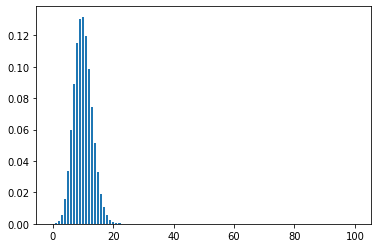

In [106]:
for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr)

График скошен в левую сторону из-за малой вероятности, с вероятностью 10% при 100 попытках количество успехов будет не больше 22.

In [107]:
#mu = 100 # среднее значение распределения

In [108]:
#sigma = 100*0.1 #стандартное отклонение распределения

In [109]:
#prob = 1-0.05 # вероятность

In [110]:
#distr = st.norm(mu, sigma) 

In [111]:
#n_shipment = distr.ppf(1-prob)

In [112]:
#print('Количество промокодов:', int(n_shipment))

План: 100 существующих клиентов должны продлить эту подписку. 10% что подписку оформят, n возьмем 1000.

In [113]:
p = 0.1

In [114]:
k = 100

In [115]:
n = 1000

In [116]:
prob = st.binom.cdf(k, n, p)

In [117]:
prob

0.5265990812951653

In [118]:
while prob > 0.05:
    n +=1
    prob = st.binom.cdf(k, n, p)
print(n)

1172


Для того, что бы вероятность не выполнения плата была 5%, нужно разослать 1172 промокода.

7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. 
Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [119]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

In [120]:
# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

In [121]:
# задаём нормальное распределение
distr = st.norm(mu, sigma) 

In [122]:
result = distr.cdf(399500)
print(result)

0.15371708296369768


15.37% вероятность того, что уведомлений откроют менее 399,5 тыс. пользователей.

#### Шаг 8. Общий вывод

Загрузили 3 датафрейма: users_go.csv - данные о пользователях, rides_go.csv - данные о поездках, subscriptions_go.csv - данные о подписках.

Проверили данные на пропуски, изменили формат в data_rides_go столбце date к типу даты pandas. В таблице data_rides_go ждобавим столбец, обозначающий месяц.Были убраны дубликаты в data_users_go.

Наиболее распространный город является Пятигорск, Екатеренбург и Ростов-на-Дону, меньше всего пользователей в Моксве и Тюмени. 
Чуть больше половины пользователей (54%) не имеют подписки. Платную подписку имеют 46% пользователей.
Больше всего пользователей возраста от 20 до 30 лет. Диапозон возраста пользователей составляет от 12 до 43 лет.
В основном пользователи проезжают от 2.5 км до 3,7 км. Максимальное расстояние за одну поездку составляет 7211,01 м.
Чаще всего длительность поездки состовляет 13 - 21 минут. Максимальное время поездки составило 40,82 минуты.

Объединили данные о пользователях, поездках и подписках в один датафрейм. На основе объединенного датафрейма создали еще 2 датафрейма: Для пользователей с ultra подпиской и free подпиской

Визуализировали информацию о расстоянии и времени поездки для пользоватей каждого тарифа. В основном пользователи без подписки проезжают расстояние от 2366 до 3905 м, Так же наблюдается 2 пика, один небольшой на расстоянии 500 метров и другой 2500 метров. Первый пик можно отнести к пробным заездам, второй пик можно отнести к наиболее частым поездкам. Время поездки занимает в среднем 12-21 минут. 
Пользователи с подпиской чаще всего проезжают 2785 - 3560 м. Пик расстояния приходится на 3км. Время поездки занимает в среднем 14-21 минут.
Так как численность пользователей без подписка больше, то диапозон расстояния в среднем шире, от 2366 до 3905 м, однако пользователи с платной подпиской проезжают в среднем больше минут и минимальные поздки дальше.

Создали новый датафрейм с агрегированными данными о поездках new_data на основе датафрейма с объединенными данными itog_data. Нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Также добавили столбец revenue_name с помесячной выручкой, которую принес каждый пользователь.

Проверили гипотезы:

Отвергли нулевую гипозезу. Пользователи с подпиской тратят больше времени на поездку, чем пользователи без подписки.

Проверили гипотезу, и мы не можем утверждать, что расстояние, которое проехали пользователи на тарифе ultra не превышает 3130 метров.

Проверили гипотезу, соответственно, мы можем утверждать, что выручка с пользователей на подписке ultra превышает выручку с пользователей на подписке free
